In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Load train and test data
train_df = pd.read_csv("../data/train_data.csv")
test_df = pd.read_csv("../data/test_data.csv")

In [5]:
# Assign `is_fraud` column as y
X_train = train_df.loc[:, train_df.columns != 'is_fraud']
y_train = train_df['is_fraud']

X_test = test_df.loc[:, test_df.columns != 'is_fraud']
y_test = test_df['is_fraud']

#### Random Undersampling

In [6]:
# Apply random undersampling to train dataset
rus = RandomUnderSampler(sampling_strategy=0.1, random_state=123)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
print(f'Size of X_train after random undersampling: {len(X_train_rus)}')

Size of X_train after random undersampling: 80256


#### Smote-NC

In [7]:
# Obtain indices for categorical variables
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns
categorical_columns_idx = [X_train.columns.get_loc(c) for c in categorical_columns]

# Apply SMOTE-NC on training data
sm = SMOTENC(categorical_features=categorical_columns_idx, random_state=123, sampling_strategy=0.5)
X_train_smote, y_train_smote = sm.fit_resample(X_train_rus, y_train_rus)

print(f'Train data size:{len(X_train_smote)}')
print(f'Fraud proportion in train data: {round(y_train_smote.mean(), 2)}')

Train data size:109440
Fraud proportion in train data: 0.33


### One-Hot Encoding

In [8]:
# Apply one-hot encoding on train and test data
X_train_ohe = pd.get_dummies(X_train_smote, drop_first = True)
X_test_ohe = pd.get_dummies(X_test, drop_first = True)
X_test_ohe = X_test_ohe.reindex(columns=X_train_ohe.columns, fill_value=0)

print(f'Number of columns after one-hot encoding: {len(X_train_ohe.columns)}')

Number of columns after one-hot encoding: 541


### Pipeline with Lasso

In [9]:
# Preprocessing

numeric_columns = X_train.select_dtypes(include=['number']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), 
        categorical_columns),
        ('num', StandardScaler(), numeric_columns)
    ]
)

In [10]:
# Define the pipeline with Lasso for feature selection followed by RandomForest
lasso_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(Lasso(alpha=0.001))),
    ('classifier', RandomForestClassifier(random_state=123))
])

# Define parameter grid
param_grid = {
    'classifier__n_estimators': [5, 10],
    'classifier__max_features': [10, 'log2'],
    'classifier__max_depth': [5,10],
    'classifier__criterion': ['gini', 'entropy']
}

# Set up GridSearchCV
cv_lasso_pipe = GridSearchCV(
    estimator=lasso_pipe,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='f1'
)

start_time = time.time()
# Fit the grid search
cv_lasso_pipe.fit(X_train_smote, y_train_smote)
print(f'Duration: {time.time() - start_time}')

# Get the best model
best_lasso_pipe = cv_lasso_pipe.best_estimator_



Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=10, classifier__n_estimators=5; total time=  45.3s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=10, classifier__n_estimators=5; total time=  46.7s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=10, classifier__n_estimators=5; total time=  46.8s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=10, classifier__n_estimators=5; total time=  46.7s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=10, classifier__n_estimators=5; total time=  47.0s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=10, classifier__n_estimators=10; total time=  46.4s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=10, classifier__n_estim


Lasso Pipeline Results:
accuracy: 0.9974506578947369, precision: 0.9970879955990208, recall: 0.9971765350877193, f1: 0.9971322455740463
AUC: 0.9972


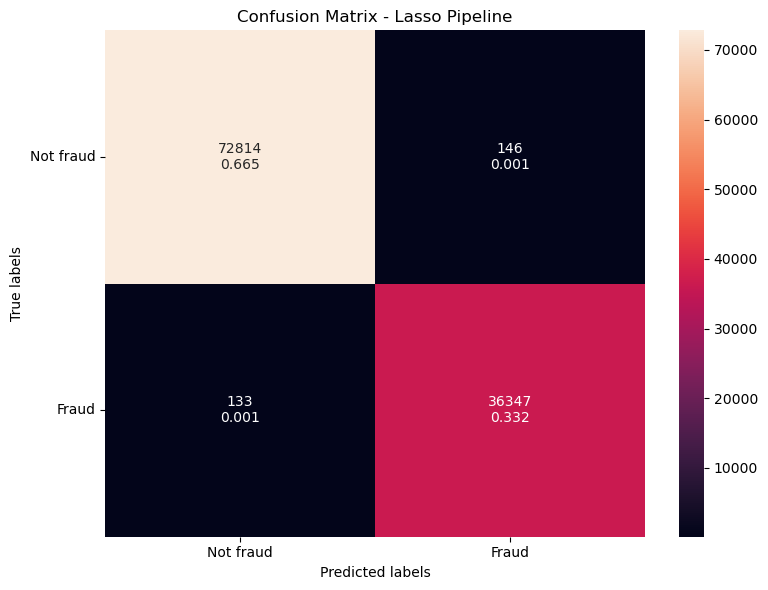

In [12]:
# Evaluate using cross-validation
sk_folds_lasso = StratifiedKFold(5, shuffle=True, random_state=123)
y_pred_lasso_pipe = cross_val_predict(best_lasso_pipe, X_train_smote, y_train_smote, cv=sk_folds_lasso)

# Calculate metrics
auc_lasso_pipe = roc_auc_score(y_train_smote, y_pred_lasso_pipe)
print("\nLasso Pipeline Results:")
print(f"accuracy: {accuracy_score(y_train_smote, y_pred_lasso_pipe)}, "
      f"precision: {precision_score(y_train_smote, y_pred_lasso_pipe, average='macro', zero_division=0.0)}, "
      f"recall: {recall_score(y_train_smote, y_pred_lasso_pipe, average='macro')}, "
      f"f1: {f1_score(y_train_smote, y_pred_lasso_pipe, average='macro', zero_division=0.0)}")
print(f'AUC: {round(auc_lasso_pipe, 4)}')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_lasso = confusion_matrix(y_train_smote, y_pred_lasso_pipe)

# Format text in boxes
group_counts = ["{0:g}".format(value) for value in cm_lasso.flatten()]
group_percentages = ["{0:.3f}".format(value) for value in cm_lasso.flatten()/np.sum(cm_lasso)]
values = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
values = np.asarray(values).reshape(2, 2)

# Create plot for Lasso Pipeline
ax = plt.subplot()
sns.heatmap(cm_lasso, annot=values, fmt='')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - Lasso Pipeline')
ax.xaxis.set_ticklabels(['Not fraud', 'Fraud'])
ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation=0)
plt.tight_layout()
plt.show()

In [15]:
# Report chosen hyperparameters
print(f'Chosen hyperparameters: {cv_lasso_pipe.best_params_}')

# Get feature names after preprocessing
preprocessor = best_lasso_pipe.named_steps['preprocessor']
preprocessed_features = preprocessor.get_feature_names_out()

# Identify which features were selected
selected_features_mask = best_lasso_pipe.named_steps['feature_selection'].get_support()
selected_features = preprocessed_features[selected_features_mask]  # Use preprocessed_features instead of X_train_smote.columns

# Print selected features 
print("Selected features:")
for i, feature in enumerate(selected_features):
    print(f"{i+1}. {feature}")

# Print total count
print(f"\nTotal selected features: {len(selected_features)} out of {len(preprocessed_features)}")

Chosen hyperparameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__max_features': 10, 'classifier__n_estimators': 10}
Selected features:
1. cat__category_grocery_net
2. cat__category_grocery_pos
3. cat__category_misc_net
4. cat__category_shopping_net
5. cat__trans_quarter_2021Q2
6. cat__trans_quarter_2022Q1
7. num__amt
8. num__hour
9. num__year
10. num__prev_trans_fraud
11. num__count_fraud_7days
12. num__acc_fraud_count
13. num__merchant_prev_trans_fraud
14. num__merchant_count_fraud_past7days
15. num__merchant_acc_fraud_count
16. num__transaction_risk_score
17. num__hourly_risk_score
18. num__visited_cat
19. num__city_population_class
20. num__interval
21. num__first_second_purchase
22. num__influential_merchant

Total selected features: 22 out of 548



Top 10 most important features:
                      Feature  Importance
17                visited_cat    0.574862
9            prev_trans_fraud    0.188408
6                         amt    0.100275
10          count_fraud_7days    0.070314
12  merchant_prev_trans_fraud    0.026638
16          hourly_risk_score    0.021996
7                        hour    0.006529
11            acc_fraud_count    0.005774
19                   interval    0.001786
15     transaction_risk_score    0.000801


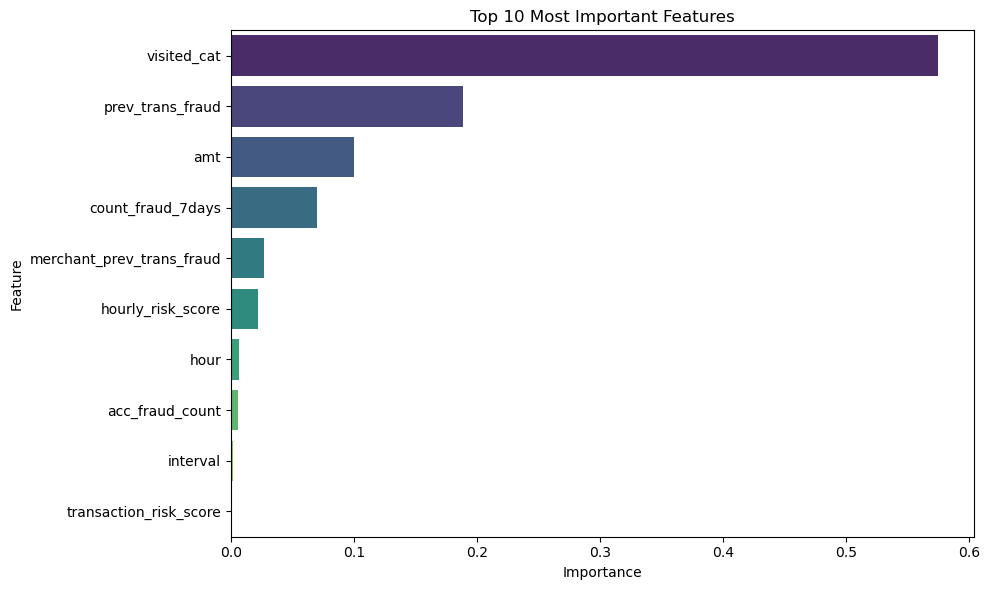

In [16]:
# Get feature importances from the classifier
feature_importances = best_lasso_pipe.named_steps['classifier'].feature_importances_

# Create dataframe of importances
importance_df = pd.DataFrame({
    'Feature': [x[5:] for x in selected_features],
    'Importance': feature_importances
})

top10_df = importance_df.sort_values(by='Importance', ascending=False)[:10]

print('\nTop 10 most important features:')
print(top10_df)

# Graph of Features according to their importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top10_df, palette='viridis')
plt.title('Top 10 Most Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### Pipeline with RFECV

Fitting RFECV pipeline with GridSearchCV - this may take some time...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting estimator with 541 features.
Fitting estimator with 487 features.
Fitting estimator with 433 features.
Fitting estimator with 379 features.
Fitting estimator with 325 features.
Fitting estimator with 271 features.
Fitting estimator with 217 features.
Fitting estimator with 163 features.
Fitting estimator with 541 features.
Fitting estimator with 487 features.
Fitting estimator with 433 features.
Fitting estimator with 379 features.
Fitting estimator with 325 features.
Fitting estimator with 271 features.
Fitting estimator with 217 features.
Fitting estimator with 163 features.
Fitting estimator with 109 features.
Fitting estimator with 541 features.
Fitting estimator with 487 features.
Fitting estimator with 433 features.
Fitting estimator with 379 features.
Fitting estimator with 325 features.
Fitting estimator with 271 features.
Fitting estimator

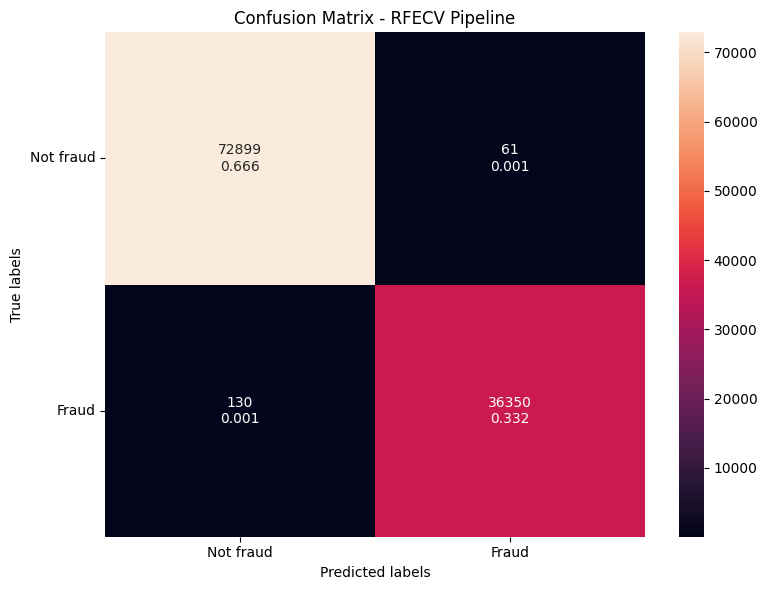

Chosen hyperparameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 15, 'classifier__max_features': 20, 'classifier__n_estimators': 150}

Optimal number of features selected by RFECV: 109
Selected features: ['zip', 'city_pop', 'amt', 'hour', 'year', 'age', 'prev_trans_fraud', 'count_fraud_7days', 'acc_fraud_count', 'merchant_prev_trans_fraud', 'merchant_count_fraud_past7days', 'merchant_acc_fraud_count', 'transaction_risk_score', 'hourly_risk_score', 'visited_cat', 'city_population_class', 'interval', 'first_second_purchase', 'interval_deviation', 'influential_merchant', 'gender_M', 'state_CA', 'state_FL', 'state_GA', 'state_IL', 'state_KS', 'state_MA', 'state_MD', 'state_MI', 'state_MN', 'state_NC', 'state_NJ', 'state_NY', 'state_OH', 'state_OK', 'state_PA', 'state_SD', 'state_TN', 'state_TX', 'state_VA', 'state_WI', 'job_Actor', 'job_Barista', 'job_Clothing/textile technologist', 'job_Copywriter', 'job_Designer', 'job_Electronics engineer', 'job_Engineer', 'job_Geologi

AttributeError: 'RFECV' object has no attribute 'grid_scores_'

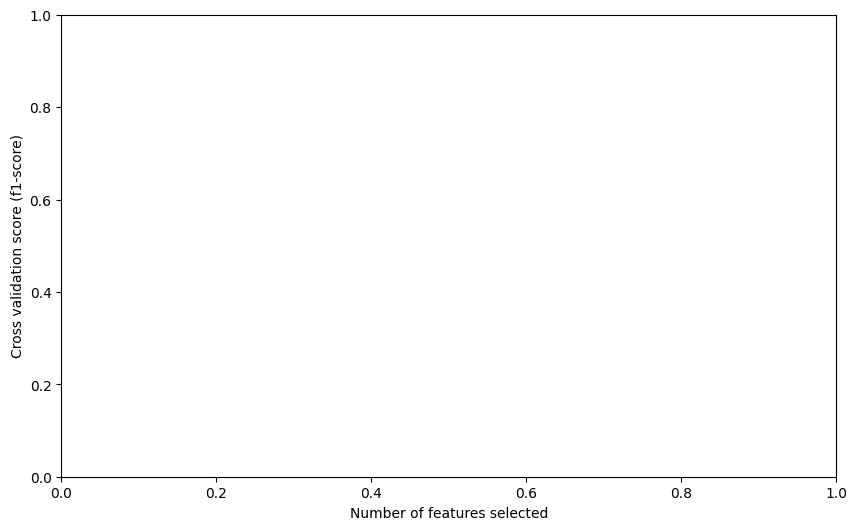

In [13]:
# Using a small RandomForest as the estimator for RFECV
rfecv_pipe = Pipeline([
    ('feature_selection', RFECV(
        estimator=RandomForestClassifier(n_estimators=100, random_state=123),
        step=0.1,  # Remove 10% of features at each iteration (a bit faster than 5 features since we have 524 columnns)
        cv=5,
        scoring='f1',
        min_features_to_select=5,
        n_jobs=-1,
        verbose=1
    )),
    ('classifier', RandomForestClassifier(random_state=123))
])

# Define parameter grid
param_grid = {
    'classifier__n_estimators': [100, 150],
    'classifier__max_features': ['sqrt', 'log2', 20],
    'classifier__max_depth': [10, 15],
    'classifier__criterion': ['gini', 'entropy']
}

# Set up GridSearchCV
cv_rfecv_pipe = GridSearchCV(
    estimator=rfecv_pipe,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='f1'
)

# Fit the grid search
print("Fitting RFECV pipeline with GridSearchCV - this may take some time...")
cv_rfecv_pipe.fit(X_train_ohe, y_train_smote)

# Get the best model
best_rfecv_pipe = cv_rfecv_pipe.best_estimator_

# Evaluate using cross-validation
sk_folds_rfecv = StratifiedKFold(5, shuffle=True, random_state=123)
y_pred_rfecv_pipe = cross_val_predict(best_rfecv_pipe, X_train_ohe, y_train_smote, cv=sk_folds_rfecv)

# Calculate metrics
auc_rfecv_pipe = roc_auc_score(y_train_smote, y_pred_rfecv_pipe)
print("\nRFECV Pipeline Results:")
print(f"accuracy: {accuracy_score(y_train_smote, y_pred_rfecv_pipe)}, "
      f"precision: {precision_score(y_train_smote, y_pred_rfecv_pipe, average='macro', zero_division=0.0)}, "
      f"recall: {recall_score(y_train_smote, y_pred_rfecv_pipe, average='macro')}, "
      f"f1: {f1_score(y_train_smote, y_pred_rfecv_pipe, average='macro', zero_division=0.0)}")
print(f'AUC: {round(auc_rfecv_pipe, 2)}')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_rfecv = confusion_matrix(y_train_smote, y_pred_rfecv_pipe)

# Format text in boxes
group_counts = ["{0:g}".format(value) for value in cm_rfecv.flatten()]
group_percentages = ["{0:.3f}".format(value) for value in cm_rfecv.flatten()/np.sum(cm_rfecv)]
values = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
values = np.asarray(values).reshape(2, 2)

# Create plot for RFECV Pipeline
ax = plt.subplot()
sns.heatmap(cm_rfecv, annot=values, fmt='')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - RFECV Pipeline')
ax.xaxis.set_ticklabels(['Not fraud', 'Fraud'])
ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation=0)
plt.tight_layout()
plt.show()

# Report chosen hyperparameters
print(f'Chosen hyperparameters: {cv_rfecv_pipe.best_params_}')

# Get number of selected features
n_features = best_rfecv_pipe.named_steps['feature_selection'].n_features_

# Get selected features
selected_features_mask = best_rfecv_pipe.named_steps['feature_selection'].get_support()
selected_features = X_train_ohe.columns[selected_features_mask]
print(f"\nOptimal number of features selected by RFECV: {n_features}")
print("Selected features:", selected_features.tolist())

# Get feature importances from the classifier
feature_importances = best_rfecv_pipe.named_steps['classifier'].feature_importances_

# Create dataframe of importances
importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': feature_importances
})

print('\nTop 10 most important features:')
print(importance_df.sort_values(by='Importance', ascending=False)[:10])

# Plot the number of features and cross-validation scores
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (f1-score)")
plt.plot(
    range(1, len(best_rfecv_pipe.named_steps['feature_selection'].grid_scores_) + 1),
    best_rfecv_pipe.named_steps['feature_selection'].grid_scores_
)
plt.title("RFECV Feature Selection Score")
plt.tight_layout()
plt.show()